In [1]:
import sympy
import numpy             as np
import matplotlib.pyplot as plt
import math

from sympy                    import *
from scipy.sparse import diags, kron, eye, block_diag, csr_matrix

# Introduction

This notebook finds the apparent horizon $h(\theta, \phi)$ by solving the expansion equation $\Theta = 0$. The principle on how this is being done is explained in the summary file.

## Step 1: Calculate expansion equation
***

The script below calculates the expansion equation symbolically using the SymPy library. It refers to the notebook "AppHor_conformal.ipynb" which contains all the necessary ingredients for calculating the equation. It requires as input the 3+1 ADM components $\alpha, \beta$ and $\psi^4$ and returns the expansion function. Note that this solver assumes a spherical coordinate system and in the current version a conformally flat metric.

In [6]:
# Run the notebook with all help functions

%run AppHor_conformal.ipynb

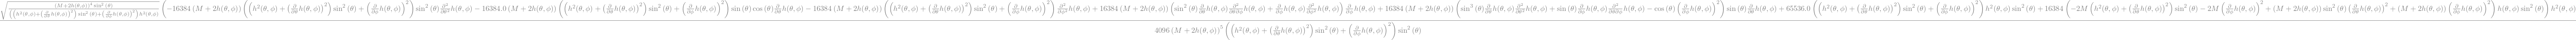

In [7]:
'''
Large function which calculates the expansion equation from alpha, beta, psi4, coordinates and h
'''



def final(alpha, beta, psi4, coords, h):
    '''
    param alpha: lapse function      --> function of (r, theta, phi)
    param beta: shift vector         --> 3-vector function of (r, theta, phi)
    param psi4: conformal factor     --> function of (r, theta, phi)
    param coords: coordinate system  --> list of coordinates
    param h: horizon function        --> scalar function dependent on theta, phi

    return: symbolic sympy expression of the expansion equation
    '''

    
    s_inv_norm = s_norm(h, s, psi4, coords, eta_inv)                    # inverse s-vector (normalized)
    
    christoffel = christoffel_symbols(psi4, eta, eta_inv, coords)       # Christoffel symbols of gamma 3-metric
    
    n_up = norm_up(alpha, beta, coords)                                 # normal vector to hypersurface (index up)
    
    n_down = norm_down(alpha, beta, psi4, eta, coords)                  # normal vector to hypersurface (index down)
    
    cur = extrinsic_curvature(n_up, n_down, christoffel, coords)        # extrinsic curvature (K_ij)
    
    exp = expansion(christoffel, s_inv_norm, cur, coords)               # expansion equation

    exp = exp.subs(r, h)                                                # replace r by h

    
    return exp



exp_eq = sp.simplify(final(alpha, beta, psi4, coords, h))
display(exp_eq)

### Step 1.1: Conversion
***

In order to evaluate the expression we convert it to a string and replace the continuous variables by their discretizations.

In [8]:
from sympy.printing.lambdarepr import lambdarepr


def subs_der(expr):
    '''
    param expr: symbolic expression in which to replace derivatives

    return: string with derivatives of h replaced by symbols X, Y, Z, U, V, W
    '''

    coords = [theta, phi]
    x = Function('x')(theta, phi)
    y = Function('y')(theta, phi)
    z = Function('z')(theta, phi)
    u = Function('u')(theta, phi)
    v = Function('v')(theta, phi)
    w = Function('w')(theta, phi)
    H, X, Y, Z, U, V, W = symbols('H, X, Y, Z, U, V, W')
    funcs = [x, y, z, u, v, w]
    syms = [X, Y, Z, U, V, W]
    m = len(coords)
    n = len(funcs)
    
    for i in range(m):
        expr = expr.subs(diff(h, coords[i]), funcs[3*i])
        for j in range(m):
            expr = expr.subs(diff(funcs[3*i], coords[j]), funcs[3*i+j+1])
    for k in range(n):
        expr = expr.subs(funcs[k], syms[k])
    
    expr = expr.subs(h, H)
    expr = expr.subs(M, "2")    # Replace M by 2 for numerical evaluation
        
    return lambdarepr(expr)

symp_expr = subs_der(exp_eq)
print(symp_expr)

(1/4096)*H**2*sqrt((2*H + 2)**4*math.sin(theta)**2/(H**2*(U**2 + (H**2 + X**2)*math.sin(theta)**2)))*(65536.0*H**2*(U**2 + (H**2 + X**2)*math.sin(theta)**2)*math.sin(theta)**2 + 16384*H*(U**2*(2*H + 2) - 4*U**2 + X**2*(2*H + 2)*math.sin(theta)**2 - 4*(H**2 + X**2)*math.sin(theta)**2)*math.sin(theta)**2 + 16384*U*(2*H + 2)*(U*W + X*Z*math.sin(theta)**2) - 16384*W*(2*H + 2)*(U**2 + (H**2 + X**2)*math.sin(theta)**2) - 16384.0*X*(2*H + 2)*(U**2 + (H**2 + X**2)*math.sin(theta)**2)*math.sin(theta)*math.cos(theta) + 16384*X*(2*H + 2)*(-U**2*math.cos(theta) + U*Z*math.sin(theta) + X*Y*math.sin(theta)**3)*math.sin(theta) - 16384*Y*(2*H + 2)*(U**2 + (H**2 + X**2)*math.sin(theta)**2)*math.sin(theta)**2)/((2*H + 2)**5*(U**2 + (H**2 + X**2)*math.sin(theta)**2)*math.sin(theta)**2)


In [9]:
dic = {"H":"h[i,j]", "X":"der_theta(h,delta_th,i,j)", "Y":"der_theta2(h,delta_th,i,j)", "Z":"der_theta_phi(h,delta_th,delta_ph,i,j)", "U":"der_phi(h,delta_ph,i,j)", "W":"der_phi2(h,delta_ph,i,j)", "math.sin(theta)":"np.sin(theta[i])", "math.cos(theta)":"np.cos(theta[i])", "sqrt":"np.sqrt"}

def replace_all(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

exp_final = "1/(16384 * (2+2*h[i,j]) * h[i,j]**2 * (math.sin(theta))**4) * (65536.0*H**2*(U**2 + (H**2 + X**2)*math.sin(theta)**2)*math.sin(theta)**2 + 16384*H*(U**2*(2*H + 2) - 4*U**2 + X**2*(2*H + 2)*math.sin(theta)**2 - 4*(H**2 + X**2)*math.sin(theta)**2)*math.sin(theta)**2 + 16384*U*(2*H + 2)*(U*W + X*Z*math.sin(theta)**2) - 16384*W*(2*H + 2)*(U**2 + (H**2 + X**2)*math.sin(theta)**2) - 16384.0*X*(2*H + 2)*(U**2 + (H**2 + X**2)*math.sin(theta)**2)*math.sin(theta)*math.cos(theta) + 16384*X*(2*H + 2)*(-U**2*math.cos(theta) + U*Z*math.sin(theta) + X*Y*math.sin(theta)**3)*math.sin(theta) - 16384*Y*(2*H + 2)*(U**2 + (H**2 + X**2)*math.sin(theta)**2)*math.sin(theta)**2) + der_theta2(h,delta_th,i,j) + 1/np.tan(theta[i])*der_theta(h,delta_th,i,j) + 1/(np.sin(theta[i]))**2*der_phi2(h,delta_ph,i,j) - 2*h[i,j]"
eq_temp = replace_all(exp_final, dic)
print(eq_temp)

1/(16384 * (2+2*h) * h**2 * (sin(theta))**4) * (65536.0*h[i,j]**2*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2 + 16384*h[i,j]*(der_phi(h,delta_ph,i,j)**2*(2*h[i,j] + 2) - 4*der_phi(h,delta_ph,i,j)**2 + der_theta(h,delta_th,i,j)**2*(2*h[i,j] + 2)*np.sin(theta[i])**2 - 4*(h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2 + 16384*der_phi(h,delta_ph,i,j)*(2*h[i,j] + 2)*(der_phi(h,delta_ph,i,j)*der_phi2(h,delta_ph,i,j) + der_theta(h,delta_th,i,j)*der_theta_phi(h,delta_th,delta_ph,i,j)*np.sin(theta[i])**2) - 16384*der_phi2(h,delta_ph,i,j)*(2*h[i,j] + 2)*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2) - 16384.0*der_theta(h,delta_th,i,j)*(2*h[i,j] + 2)*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])*np.cos(theta[i]) + 16384*der_theta(h,delta_th,i,j)*(2*h[i,j] + 2)*(-der_phi(h,delta_ph,i

## Step 2: Solving procedure
***

The code below solves the expansion equation numerically to find a solution for the horizon function $h(\theta, \phi)$. As explained in the summary the expansion equation is solved by separating the linear part given by $\Delta_{\theta\phi}h - 2h = \frac{\partial^2 h}{\partial \theta^2} + \cot{\theta} \frac{\partial h}{\partial \theta} + \frac{1}{\sin^2{\theta}} \frac{\partial^2 h}{\partial \phi^2} - 2h$ and then solve the linear system $A \cdot h = S(h)$.

**There is however one important modification compared to the one-dimensional symmetry cases.** Since $h$ is now a two-dimensional array, there is no direct way to perform the matrix multiplication $A \cdot h = S$ anymore. Instead, we ravel the 2D-matrix $h$ as well as the right-hand-side $S$ into 1D-arrays first, then do the matrix calculations, and then unravel $h$ back into it's original shape afterwards. We use "numpy.ravel()" for this purpose which works in the following way for this (3x3)-matrix:
\begin{equation}
    h = \begin{pmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{pmatrix} \quad \xrightarrow[]{\textnormal{np.ravel()}} \quad h_{\textnormal{raveled}} = [h_{11}, \; h_{12}, \; h_{13}, \; h_{21}, \; h_{22}, \; ..., \; h_{33}]
\end{equation}
However, this also means that the sparse matrix $A$ drastically complicates, because consecutive elements in the $\theta$-direction are now separated by $N_{\phi}$ positions. As a result, the matrix $A$ will have non-zero rows at $N_{\phi}$ separation from the main diagonal too (see construction below).

**Apart from that, special care has to be taken for the boundary conditions too.** The first row and last row of $h$ correspond to the $\theta = 0$ and $\theta = \pi$ pole respectively. Because of the ravel-construction above, this means the first and last $N_{\phi}$ rows of $A$ must be considered separately. For each "column of $\phi$" in $h$, we can again expand $h$ by a Taylor series as
\begin{equation}
    h[1] = h[0] + \Delta\theta \frac{\partial h}{\partial \theta}\Bigg|_{\theta=0} + \frac{1}{2} (\Delta\theta)^2 \frac{\partial^2 h}{\partial \theta^2}\Bigg|_{\theta=0}
\end{equation}
where we left out the index of $\phi$ for simplicity. By using the original equation $\Delta_{\theta\phi}h - 2h = S$ to replace $\frac{\partial^2 h}{\partial \theta^2}\Big|_{\theta=0}$ we obtain
\begin{equation}
    \frac{2}{(\Delta\theta)^2}(h[1]-h[0]) - 2h[0] = S
\end{equation}
where we used $\frac{\partial h}{\partial \theta}\Big|_{\theta=0} = 0$ (boundary condition) and $\frac{\partial^2 h}{\partial \phi^2}\Big|_{\theta=0}$ (because all $\phi$-values coincide at the pole). **It is this equation that we use to modify the first and last $N_{\phi}$ rows of the tridiagonal matrix (see below).**

In [4]:
'''
Discretized derivatives of h in spherical coordinates on an arbitrary grid point (theta, phi) = (i, j)
'''

# phi-derivatives (d_h/d_phi and d^2_h/d_phi^2)
# %N_ph provides periodic boundary conditions in the phi direction
def der_phi(h, delta, i, j):
    return ((h[i,(j+1)%N_ph] - h[i,j-1]) / (2*delta))

def der_phi2(h, delta, i, j):
    return ((h[i,(j+1)%N_ph] - 2*h[i,j] + h[i,j-1]) / delta**2)



# theta-derivatives (d_h/d_theta and d^2_h/d_theta^2)
def der_theta(h, delta, i, j):
    if (i == 0) or (i == len(h)-1):
        return 0    # on both poles we require zero derivative for smooth solutions
    else:
        return ((h[i+1,j] - h[i-1,j]) / (2*delta))

def der_theta2(h, delta, i, j):
    if i == 0:
        return ((h[i,j] - 2*h[i+1,j] + h[i+2,j]) / delta**2)    # forward 2nd derivative
    elif i == len(h)-1:
        return ((h[i,j] - 2*h[i-1,j] + h[i-2,j]) / delta**2)    # backward 2nd derivative
    else:
        return ((h[i+1,j] - 2*h[i,j] + h[i-1,j]) / delta**2)    # central 2nd derivative



# mixed derivative (d^2_h/(d_theta*d_phi))
def der_theta_phi(h, delta1, delta2, i, j):
    if i == 0:
        return ((h[i+1,(j+1)%N_ph] + h[i,j-1] - h[i+1,j-1] - h[i,(j+1)%N_ph]) / (2*delta1*delta2))      # forward (in theta) 2nd derivative
    elif i == len(h)-1:
        return ((h[i,(j+1)%N_ph] + h[i-1,j-1] - h[i,j-1] - h[i-1,(j+1)%N_ph]) / (2*delta1*delta2))      # backward (in theta) 2nd derivative
    else:
        return ((h[i+1,(j+1)%N_ph] + h[i-1,j-1] - h[i+1,j-1] - h[i-1,(j+1)%N_ph]) / (4*delta1*delta2))  # central 2nd derivative



#####################################################################################################################################################################################


'''
Function which calculates the non-linear right-hand-side of the expansion equation for a given h
'''
def rhs_update(h, delta_th, delta_ph, N_th, N_ph, cot_th, sin_th_inv):
    '''
    param h: horizon functions as (N_th x N_ph)-array
    params delta_th, delta_ph: theta- and phi-stepsize respectively
    params N_th, N_ph: number of theta and phi grid dimensions respectively
    param cot_th: cot(theta[i]) as N_th-array
    param sin_th_inv: 1/sin(theta[i]) as N_th-array

    return: raveled (N_th*N_ph)-array of rhs-values
    '''
    rhs = np.zeros_like(h)
    for i in range(N_th):
        for j in range(N_ph):
            rhs[i, j] = (sin_th_inv[i])**4/(16384 * (2+2*h[i,j]) * h[i,j]**2) * \
                         (65536.0*h[i,j]**2*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2 + \
                          16384*h[i,j]*(der_phi(h,delta_ph,i,j)**2*(2*h[i,j] + 2) - 4*der_phi(h,delta_ph,i,j)**2 + der_theta(h,delta_th,i,j)**2*(2*h[i,j] + 2)*np.sin(theta[i])**2 - \
                          4*(h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2 + \
                          16384*der_phi(h,delta_ph,i,j)*(2*h[i,j] + 2)*(der_phi(h,delta_ph,i,j)*der_phi2(h,delta_ph,i,j) + \
                          der_theta(h,delta_th,i,j)*der_theta_phi(h,delta_th,delta_ph,i,j)*np.sin(theta[i])**2) - \
                          16384*der_phi2(h,delta_ph,i,j)*(2*h[i,j] + 2)*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2) - \
                          16384.0*der_theta(h,delta_th,i,j)*(2*h[i,j] + 2)*(der_phi(h,delta_ph,i,j)**2 + \
                          (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])*np.cos(theta[i]) + \
                          16384*der_theta(h,delta_th,i,j)*(2*h[i,j] + 2)*(-der_phi(h,delta_ph,i,j)**2*np.cos(theta[i]) + \
                          der_phi(h,delta_ph,i,j)*der_theta_phi(h,delta_th,delta_ph,i,j)*np.sin(theta[i]) + \
                          der_theta(h,delta_th,i,j)*der_theta2(h,delta_th,i,j)*np.sin(theta[i])**3)*np.sin(theta[i]) - \
                          16384*der_theta2(h,delta_th,i,j)*(2*h[i,j] + 2)*(der_phi(h,delta_ph,i,j)**2 + \
                          (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2) + \
                          der_theta2(h,delta_th,i,j) + cot_th[i]*der_theta(h,delta_th,i,j) + (sin_th_inv[i])**2*der_phi2(h,delta_ph,i,j) - 2*h[i,j]
    
    rhs = np.ravel(rhs)   # ravel rhs to have it in appropiate form for solving the linear system A*h = rhs
    return rhs



#####################################################################################################################################################################################


'''
Series of functions to construct sparse-structure matrix (similar to the tridiagonal in 1D) for the linear left-hand-side of the equation (= spherical Laplacian - 2h)
It should be noted this matrix matches the raveled structure of h, therefore being a (n x n)-matrix with n = N_th*N_ph
'''

# Constructs tridiagonal matrix for the d^2_h/d_theta^2 contribution
def theta_2(delta_th, N_th, N_ph):
    n = N_th*N_ph
    main_diag = -2/delta_th**2 * np.ones(n)                # main diagonal
    off_diag = 1/delta_th**2 * np.ones(n+N_ph)             # upper and lower diagonals
    diagonals = [off_diag, main_diag, off_diag]
    offsets = [-N_ph, 0, N_ph]                             # upper and lower diagonals need N_ph offset because of the raveled h
    sparse_part = diags(diagonals, offsets, shape=(n,n))   # create sparse matrix
    return sparse_part

# Constructs tridiagonal matrix for the cot(theta) * d_h/d_theta contribution
def theta_1(delta_th, N_th, N_ph, cot_th):
    n = N_th*N_ph
    main_diag = np.zeros(n)                                # main diagonal
    repeated_cot = np.repeat(cot_th, N_ph)                 # for each value of theta, there are N_ph identical values for cot(theta)
    off_diag_r = repeated_cot[:(-N_ph)]/(2*delta_th)       # upper diagonal
    off_diag_l = repeated_cot[N_ph:]/(2*delta_th)          # lower diagonal
    diagonals = [-off_diag_l, main_diag, off_diag_r]
    offsets = [-N_ph, 0, N_ph]                             # same N_ph offset
    sparse_part = diags(diagonals, offsets, shape=(n,n))   # create sparse matrix
    return sparse_part

# Constructs tridiagonal matrix for the 1/sin^2(theta) * d^2_h/d_phi^2 contribution
def phi_2(delta_ph, N_th, N_ph):
    main_diag = -2/delta_ph**2 * np.ones(N_ph)                                 # main diagonal
    off_diag = 1/delta_ph**2 * np.ones(N_ph-1)                                 # upper and lower diagonal
    periodic_diag = 1/delta_ph**2                                              # accounts for periodicity on the boundaries of phi (0, 2*pi)
    diagonals = [periodic_diag, off_diag, main_diag, off_diag, periodic_diag]
    offsets = [-(N_ph-1), -1, 0, 1, N_ph-1]
    block = diags(diagonals, offsets, shape=(N_ph,N_ph))                       # create block-matrix for each row of phi-values (corresponding to a fixed theta)

    blocks = []                                                                # make diagonal block-matrix with N_th blocks
    z = np.zeros((N_ph,N_ph))                                                  # except first and last blocks corresponding to the poles (theta = 0, pi)
    blocks.append(z)
    for i in range(1,N_th-1):
        blocks.append(1/(np.sin(theta[i]))**2 * block)
    blocks.append(z)
    sparse_part = block_diag(blocks)
    return sparse_part

# Constructs tridiagonal matrix for the proportional-h contribution
def cte(N_th, N_ph):
    n = N_th*N_ph
    sparse_part = np.diag([1] * n)    # one main diagonal
    return sparse_part





# Constructs the full tridiagonal matrix by combining all contributions from the above functions
def sparse_lapl(N_th, N_ph, delta_th, delta_ph, cot_th):

    # Create sparse matrix for "Delta_(theta,phi)(h) - 2*h"
    sparse_matrix = theta_2(delta_th, N_th, N_ph) + theta_1(delta_th, N_th, N_ph, cot_th) + phi_2(delta_ph, N_th, N_ph) - 2*cte(N_th, N_ph)

    sparse_matrix = csr_matrix(sparse_matrix)

    # The boundaries on the poles (theta = 0, pi) are handled separately (see calculation above under "Step 2")
    # These correspond to the first and last N_ph rows of the matrix
    for i in range(N_ph):
        sparse_matrix[i, i] = -2/delta_th**2 - 2
        sparse_matrix[i, i+N_ph] = 2/delta_th**2
        sparse_matrix[-1-i, -1-i] = -2/delta_th**2 - 2
        sparse_matrix[-1-i, -1-i-N_ph] = 2/delta_th**2

    return sparse_matrix

In [5]:
'''
Initialize data
'''

# Grid dimensions in theta and phi (currently needs to be same number(?))
N_th = 5
N_ph = 5


# Construct the grid and grid spacing
theta = np.linspace(0, np.pi, N_th)
phi = np.linspace(0, 2*np.pi, N_ph)
delta_th = theta[1] - theta[0]
delta_ph = phi[1] - phi[0]

# Pre-calculate cot(theta) and 1/sin(theta) --> add 0 to boundaries to avoid infinities
cot_th = 1 / np.tan(theta[1:N_th-1])
cot_th = np.insert(cot_th, 0, 0)
cot_th = np.append(cot_th, 0)
sin_th_inv = 1 / np.sin(theta[1:N_th-1])
sin_th_inv = np.insert(sin_th_inv, 0, 0)
sin_th_inv = np.insert(sin_th_inv, -1, 0)


# Initial guess for h
h = np.ones((N_th, N_ph))

pert = np.zeros_like(h)
for i in range(N_th):
    for j in range(N_ph):
        pert[i,j] = 0.1*sin(theta[i]) + 0.1*cos(phi[j])
#h = np.ones((N_th, N_ph)) + pert


##################################################################################################


'''
Function which solves the system for h iteratively
'''

def solve_h(h, N_th, N_ph, delta_th, delta_ph, m, n):
    '''
    param h: initial guess surface h, (N_th x N_ph)-array
    params N_th, N_ph: grid dimensions
    params delta_th, delta_ph: grid spacing
    param m: sparse matrix for linear left-hand-side
    param n: number of iterations

    return h_new: solution for h after n iterations
    return differences: measure for the difference delta_h between two consecutive solutions of h
    '''
    
    h_new = h
    differences = []
    
    for _ in range(n):
        rhs = rhs_update(h_new, delta_th, delta_ph, N_th, N_ph, cot_th, sin_th_inv)  # calculate rhs
        h_old = h_new                                                                # keep track of previous solution to calculate difference
        h_new = np.linalg.solve(m, rhs)                                              # solve the linear system m*h = rhs to h
        h_new = h_new.reshape(N_th, N_ph)                                            # reshape h back to a 2D matrix
        diff = 0
        for i in range(N_th):
            for j in range(N_ph):
                diff += (h_new[i,j] - h_old[i,j])**2
        differences.append(diff)
        
    return h_new, differences


##################################################################################################


# Number of iterations
n_iter = 5

# Sparse matrix
m = sparse_lapl(N_th, N_ph, delta_th, delta_ph, cot_th)
m = m.todense()

# Solve for h
sol_h, differences = solve_h(h, N_th, N_ph, delta_th, delta_ph, m, n_iter)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


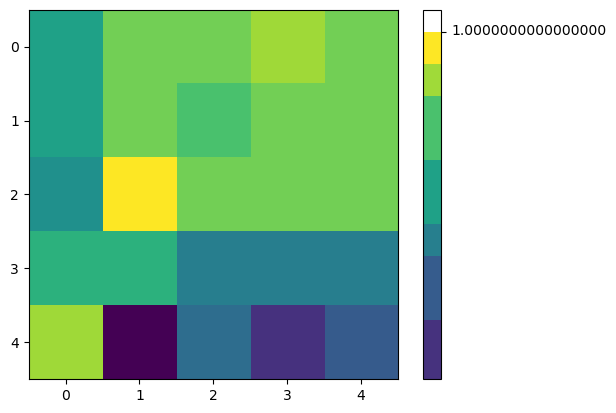

In [6]:
print(sol_h)
plt.imshow(sol_h)
plt.colorbar()

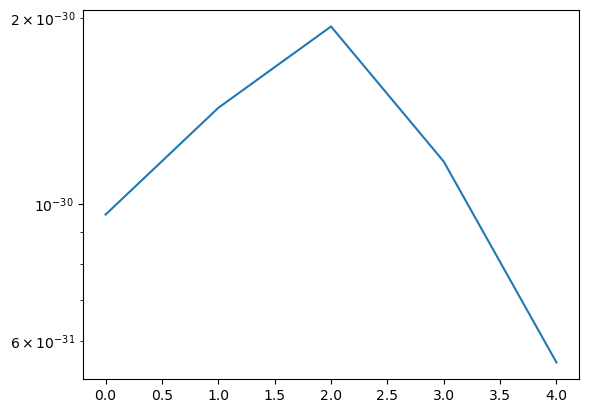

In [93]:
plt.plot(differences);
plt.yscale('log')

Condition Number of m: 5.7679107332000275
-2.9934257405779333e+18


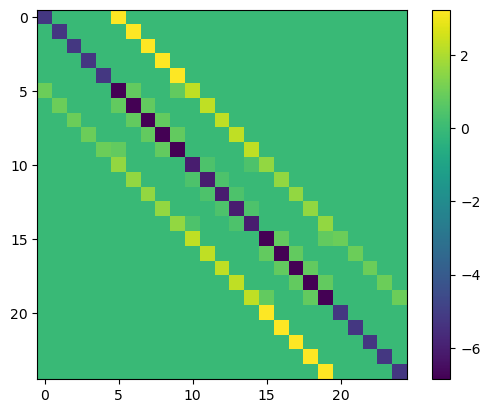

In [97]:
plt.imshow(m)
plt.colorbar()
condition_number = np.linalg.cond(m)
print(f"Condition Number of m: {condition_number}")
det = np.linalg.det(m)
print(det)

***

***

***

***

# Backup

In [ ]:
'''
Before optimisation


# phi-derivatives
def der_phi(h, delta, i, j):
    return ((h[i,(j+1)%N_ph] - h[i,j-1]) / (2*delta))

def der_phi2(h, delta, i, j):
    return ((h[i,(j+1)%N_ph] - 2*h[i,j] + h[i,j-1]) / delta**2)



# theta-derivatives
def der_theta(h, delta, i, j):
    if (i == 0) or (i == len(h)-1):
        return 0
    else:
        return ((h[i+1,j] - h[i-1,j]) / (2*delta))

def der_theta2(h, delta, i, j):
    if i == 0:
        return ((h[i,j] - 2*h[i+1,j] + h[i+2,j]) / delta**2)
    elif i == len(h)-1:
        return ((h[i,j] - 2*h[i-1,j] + h[i-2,j]) / delta**2)
    else:
        return ((h[i+1,j] - 2*h[i,j] + h[i-1,j]) / delta**2)



# mixed derivative
def der_theta_phi(h, delta1, delta2, i, j):
    if i == 0:
        return ((h[i+1,(j+1)%N_ph] + h[i,j-1] - h[i+1,j-1] - h[i,(j+1)%N_ph]) / (2*delta1*delta2))
    elif i == len(h)-1:
        return ((h[i,(j+1)%N_ph] + h[i-1,j-1] - h[i,j-1] - h[i-1,(j+1)%N_ph]) / (2*delta1*delta2))
    else:
        return ((h[i+1,(j+1)%N_ph] + h[i-1,j-1] - h[i+1,j-1] - h[i-1,(j+1)%N_ph]) / (4*delta1*delta2))






def rhs_update(h, delta_th, delta_ph, N_th, N_ph):
    rhs = np.zeros_like(h)
    for i in range(N_th):
        for j in range(N_ph):
            rhs[i, j] = 1/(16384 * (1+2*h[i,j]) * h[i,j]**2 * (sin(theta[i]))**4) * (65536.0*h[i,j]**2*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2 + 16384*h[i,j]*(der_phi(h,delta_ph,i,j)**2*(2*h[i,j] + 1) - 2*der_phi(h,delta_ph,i,j)**2 + der_theta(h,delta_th,i,j)**2*(2*h[i,j] + 1)*np.sin(theta[i])**2 - 2*(h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2 + 16384*der_phi(h,delta_ph,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)*der_phi2(h,delta_ph,i,j) + der_theta(h,delta_th,i,j)*der_theta_phi(h,delta_th,delta_ph,i,j)*np.sin(theta[i])**2) - 16384*der_phi2(h,delta_ph,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2) - 16384.0*der_theta(h,delta_th,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])*np.cos(theta[i]) + 16384*der_theta(h,delta_th,i,j)*(2*h[i,j] + 1)*(-der_phi(h,delta_ph,i,j)**2*np.cos(theta[i]) + der_phi(h,delta_ph,i,j)*der_theta_phi(h,delta_th,delta_ph,i,j)*np.sin(theta[i]) + der_theta(h,delta_th,i,j)*der_theta2(h,delta_th,i,j)*np.sin(theta[i])**3)*np.sin(theta[i]) - 16384*der_theta2(h,delta_th,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2) + der_theta2(h,delta_th,i,j) + 1/np.tan(theta[i])*der_theta(h,delta_th,i,j) + 1/(np.sin(theta[i]))**2*der_phi2(h,delta_ph,i,j) - 2*h[i,j]
    rhs = np.ravel(rhs)
    return rhs






def theta_2(delta_th, N_th, N_ph):
    n = N_th*N_ph
    main_diag = -2/delta_th**2 * np.ones(n)
    off_diag = 1/delta_th**2 * np.ones(n)
    main_diag[:N_ph] = 0
    main_diag[-N_ph:] = 0
    off_diag[:N_ph] = 0
    off_diag[-N_ph:] = 0
    diagonals = [off_diag, main_diag, off_diag]
    offsets = [-N_ph, 0, N_ph]
    tridig_part = diags(diagonals, offsets, shape=(n,n))
    return tridig_part

def theta_1(delta_th, N_th, N_ph, cot_th):
    n = N_th*N_ph
    main_diag = np.zeros(n)
    repeated_cot = np.repeat(cot_th, N_ph)
    off_diag_r = repeated_cot[:(-N_ph)]/(2*delta_th)
    off_diag_l = repeated_cot[N_ph:]/(2*delta_th)
    main_diag[:N_ph] = 0
    main_diag[-N_ph:] = 0
    off_diag_r[:N_ph] = 0
    off_diag_r[-N_ph:] = 0
    off_diag_l[:N_ph] = 0
    off_diag_l[-N_ph:] = 0
    diagonals = [-off_diag_l, main_diag, off_diag_r]
    offsets = [-N_ph, 0, N_ph]
    tridig_part = diags(diagonals, offsets, shape=(n,n))
    return tridig_part

def phi_2(delta_ph, N_th, N_ph):
    main_diag = -2/delta_ph**2 * np.ones(N_ph)
    off_diag = 1/delta_ph**2 * np.ones(N_ph-1)
    periodic_diag = 1/delta_ph**2
    diagonals = [periodic_diag, off_diag, main_diag, off_diag, periodic_diag]
    offsets = [-(N_ph-1), -1, 0, 1, N_ph-1]
    block = diags(diagonals, offsets, shape=(N_ph,N_ph))

    blocks = []
    z = np.zeros((N_ph,N_ph))
    blocks.append(z)
    for i in range(1,N_th-1):
        blocks.append(1/(np.sin(theta[i]))**2 * block)
    blocks.append(z)
    tridig_part = block_diag(blocks)
    return tridig_part

def cte(N_th, N_ph):
    n = N_th*N_ph
    tridig_part = np.diag([2] * n)
    return tridig_part






def tridig_lapl(N_th, N_ph, delta_th, delta_ph, cot_th, sin_th):

    n = N_th*N_ph

    tridig_matrix = theta_2(delta_th, N_th, N_ph) + theta_1(delta_th, N_th, N_ph, cot_th) + phi_2(delta_ph, N_th, N_ph) - cte(N_th, N_ph)

    tridig_matrix = sp.csr_matrix(tridig_matrix)

    for i in range(N_ph):
        tridig_matrix[i, i] = -2/delta_th**2 - 2
        tridig_matrix[i, i+N_ph] = 2/delta_th**2
        tridig_matrix[-1-i, -1-i] = -2/delta_th**2 - 2
        tridig_matrix[-1-i, -1-i-N_ph] = 2/delta_th**2

    return tridig_matrix

'''

In [ ]:
'''
def finite_difference_matrix(N_th, N_ph, var, der_ord, delta_th, delta_ph):

    n = N_th*N_ph

    if var == "theta":
        if der_ord == 1:
            main_diag = np.zeros(n)
            off_diag = 1/(2*delta_th) * np.ones(n-1)
            diagonals = [-off_diag, main_diag, off_diag]
            offsets = [-N_ph, 0, N_ph]
            tridig_matrix = diags(diagonals, offsets, shape=(n,n))
    
        elif der_ord == 2:
            main_diag = -2/delta_th**2 * np.ones(n)
            off_diag = 1/delta_th**2 * np.ones(n-1)
            diagonals = [off_diag, main_diag, off_diag]
            offsets = [-N_ph, 0, N_ph]
            tridig_matrix = diags(diagonals, offsets, shape=(n,n))

    elif var == "phi":
        if der_ord == 1:
            main_diag = np.zeros(N_ph)
            off_diag = 1/(2*delta_ph) * np.ones(N_ph-1)
            periodic_diag = 1/(2*delta_ph)
            diagonals = [periodic_diag, -off_diag, main_diag, off_diag, -periodic_diag]
            offsets = [-(N_ph-1), -1, 0, 1, N_ph-1]
            block = diags(diagonals, offsets, shape=(N_ph,N_ph))

            blocks = []
            for i in range(N_th):
                blocks.append(block)
            tridig_matrix = block_diag(blocks)
    
        elif der_ord == 2:
            main_diag = -2/delta_ph**2 * np.ones(N_ph)
            off_diag = 1/delta_ph**2 * np.ones(N_ph-1)
            periodic_diag = 1/delta_ph**2
            diagonals = [periodic_diag, off_diag, main_diag, off_diag, periodic_diag]
            offsets = [-(N_ph-1), -1, 0, 1, N_ph-1]
            block = diags(diagonals, offsets, shape=(N_ph,N_ph))

            blocks = []
            for i in range(N_th):
                blocks.append(block)
            tridig_matrix = block_diag(blocks)

    tridig_matrix = sp.csr_matrix(tridig_matrix)

    for i in range(N_ph):
        tridig_matrix[i, i] = -2/delta_th**2 - 2
        tridig_matrix[i, i+N_ph] = 2/delta_th**2
        tridig_matrix[-1-i, -1-i] = -2/delta_th**2 - 2
        tridig_matrix[-1-i, -1-i-N_ph] = 2/delta_th**2
        

    return tridig_matrix

test = finite_difference_matrix(3, 3, "theta", 2, 1, 1)
a = test.todense()
print(a)
'''

In [ ]:
'''
rhs[i, j] = (sin_th_inv[i])**4/(16384 * (1+2*h[i,j]) * h[i,j]**2) * \
                         (65536.0*h[i,j]**2*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2 + \
                         16384*h[i,j]*(der_phi(h,delta_ph,i,j)**2*(2*h[i,j] + 1) - 2*der_phi(h,delta_ph,i,j)**2 + der_theta(h,delta_th,i,j)**2*(2*h[i,j] + 1)*np.sin(theta[i])**2 - \
                         2*(h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2 + \
                         16384*der_phi(h,delta_ph,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)*der_phi2(h,delta_ph,i,j) + \
                         der_theta(h,delta_th,i,j)*der_theta_phi(h,delta_th,delta_ph,i,j)*np.sin(theta[i])**2) - \
                         16384*der_phi2(h,delta_ph,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2) - \
                         16384.0*der_theta(h,delta_th,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)**2 + \
                         (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])*np.cos(theta[i]) + \
                         16384*der_theta(h,delta_th,i,j)*(2*h[i,j] + 1)*(-der_phi(h,delta_ph,i,j)**2*np.cos(theta[i]) + \
                         der_phi(h,delta_ph,i,j)*der_theta_phi(h,delta_th,delta_ph,i,j)*np.sin(theta[i]) + \
                         der_theta(h,delta_th,i,j)*der_theta2(h,delta_th,i,j)*np.sin(theta[i])**3)*np.sin(theta[i]) - \
                         16384*der_theta2(h,delta_th,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)**2 + \
                         (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2) + \
                         der_theta2(h,delta_th,i,j) + cot_th[i]*der_theta(h,delta_th,i,j) + (sin_th_inv[i])**2*der_phi2(h,delta_ph,i,j) - 2*h[i,j]

1/(16384 * (1+2*h[i,j]) * h[i,j]**2 * (sin(theta[i]))**4) * \
                         (65536.0*h[i,j]**2*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2 + \
                         16384*h[i,j]*(der_phi(h,delta_ph,i,j)**2*(2*h[i,j] + 1) - 2*der_phi(h,delta_ph,i,j)**2 + der_theta(h,delta_th,i,j)**2*(2*h[i,j] + 1)*np.sin(theta[i])**2 - \
                         2*(h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2 + \
                         16384*der_phi(h,delta_ph,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)*der_phi2(h,delta_ph,i,j) + \
                         der_theta(h,delta_th,i,j)*der_theta_phi(h,delta_th,delta_ph,i,j)*np.sin(theta[i])**2) - \
                         16384*der_phi2(h,delta_ph,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)**2 + (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2) - \
                         16384.0*der_theta(h,delta_th,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)**2 + \
                         (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])*np.cos(theta[i]) + \
                         16384*der_theta(h,delta_th,i,j)*(2*h[i,j] + 1)*(-der_phi(h,delta_ph,i,j)**2*np.cos(theta[i]) + \
                         der_phi(h,delta_ph,i,j)*der_theta_phi(h,delta_th,delta_ph,i,j)*np.sin(theta[i]) + \
                         der_theta(h,delta_th,i,j)*der_theta2(h,delta_th,i,j)*np.sin(theta[i])**3)*np.sin(theta[i]) - \
                         16384*der_theta2(h,delta_th,i,j)*(2*h[i,j] + 1)*(der_phi(h,delta_ph,i,j)**2 + \
                         (h[i,j]**2 + der_theta(h,delta_th,i,j)**2)*np.sin(theta[i])**2)*np.sin(theta[i])**2) + \
                         der_theta2(h,delta_th,i,j) + 1/np.tan(theta[i])*der_theta(h,delta_th,i,j) + 1/(np.sin(theta[i]))**2*der_phi2(h,delta_ph,i,j) - 2*h[i,j]
'''